In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score

In [ ]:
data_df = pd.read_csv('../../data/processed/fully_integrated_data.csv')
data_df.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

##### Features For Driver Performance

In [ ]:
train = data_df[data_df['season'] < 2020].copy()
test = data_df[data_df['season'] >= 2020].copy()


train['driver_avg_points'] = train.groupby('driverId')['driverRacePoints'].transform('mean')
train['constructor_avg_points'] = train.groupby('constructorId')['constructorRacePoints'].transform('mean')

test['driver_avg_points'] = test['driverId'].map(train.groupby('driverId')['driverRacePoints'].mean())
test['constructor_avg_points'] = test['constructorId'].map(train.groupby('constructorId')['constructorRacePoints'].mean())

train['positions_gained'] = train['driverStartGridPos'] - train['driverFinalGridPos']
test['positions_gained'] = test['driverStartGridPos'] - test['driverFinalGridPos']


driver_consistency_train = train.groupby('driverId')['driverFinalRank'].std()
train['driver_consistency'] = train['driverId'].map(driver_consistency_train)
test['driver_consistency'] = test['driverId'].map(driver_consistency_train)

train['driver_consistency'] = train['driver_consistency'].fillna(0)
test['driver_consistency'] = test['driver_consistency'].fillna(0)

driver_overtaking_train = train.groupby('driverId')['positions_gained'].mean()
train['driver_overtaking'] = train['driverId'].map(driver_overtaking_train)
test['driver_overtaking'] = test['driverId'].map(driver_overtaking_train)

overtaking_consistency_train = train.groupby('driverId')['positions_gained'].std()
train['overtaking_consistency'] = train['driverId'].map(overtaking_consistency_train)
test['overtaking_consistency'] = test['driverId'].map(overtaking_consistency_train)

# Fill NaN with 0
train['overtaking_consistency'] = train['overtaking_consistency'].fillna(0)
test['overtaking_consistency'] = test['overtaking_consistency'].fillna(0)

# Assuming 'driverDateOfBirth' is a date and 'raceDate' is also a date
train['driverAge'] = pd.to_datetime(train['raceDate']).dt.year - pd.to_datetime(train['driverDateOfBirth']).dt.year
test['driverAge'] = pd.to_datetime(test['raceDate']).dt.year - pd.to_datetime(test['driverDateOfBirth']).dt.year

In [ ]:
driver_avg_points_train = train.groupby('driverId')['driverRacePoints'].mean().to_dict()

# Compute adaptability feature
train['driver_adaptability'] = train.apply(
    lambda row: row['driverRacePoints'] 
                if pd.notnull(row['driverRacePoints']) 
                else driver_avg_points_train.get(row['driverId'], 0),
    axis=1
)

test['driver_avg_points'] = test['driverId'].map(driver_avg_points_train)
test['driver_adaptability'] = test.apply(
    lambda row: row['driverRacePoints'] 
                if pd.notnull(row['driverRacePoints']) 
                else driver_avg_points_train.get(row['driverId'], 0),
    axis=1
)

# DNF rate = fraction of 'Retired' statuses per constructor
dnf_rate_train = train.groupby('constructorId')['driverRaceResultStatus'].apply(lambda x: (x == 'Retired').mean())
constructor_reliability_train = 1 - dnf_rate_train

train['constructor_reliability'] = train['constructorId'].map(constructor_reliability_train)
test['constructor_reliability'] = test['constructorId'].map(constructor_reliability_train)


constructor_wins_train = train.groupby('constructorId')['constructorChampionshipStandingWins'].sum()
train['constructor_historical_success'] = train['constructorId'].map(constructor_wins_train)
test['constructor_historical_success'] = test['constructorId'].map(constructor_wins_train)





##### Interaction Features between constructor and  drivers

In [109]:
train['driver_team_synergy'] = train['driver_avg_points'] * train['constructor_avg_points']
test['driver_team_synergy'] = test['driver_avg_points'] * test['constructor_avg_points']

train['driver_team_gap'] = train['driver_avg_points'] - train['constructor_avg_points']
test['driver_team_gap'] = test['driver_avg_points'] - test['constructor_avg_points']

train['driver_team_ratio'] = train['driver_avg_points'] / (train['constructor_avg_points'] + 1e-6)
test['driver_team_ratio'] = test['driver_avg_points'] / (test['constructor_avg_points'] + 1e-6)

In [110]:
features = [
    'driver_avg_points', 'driver_consistency', 'driver_overtaking', 'overtaking_consistency',
    'driver_adaptability', 'driverAge', 'constructor_avg_points', 'constructor_reliability',
    'constructor_historical_success'
]

target = 'driverRacePoints'

In [ ]:
X_train = train[features].copy()
y_train = train['driverRacePoints'].copy()

X_test = test[features].copy()
y_test = test['driverRacePoints'].copy()

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/50


/home/karthick-js/Documents/Programs/Data_Premier_League/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2938 - mae: 0.2247 - val_loss: 0.1603 - val_mae: 0.1153
Epoch 2/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1205 - mae: 0.0808 - val_loss: 0.0918 - val_mae: 0.0649
Epoch 3/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0795 - mae: 0.0556 - val_loss: 0.1123 - val_mae: 0.0955
Epoch 4/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0612 - mae: 0.0459 - val_loss: 0.0707 - val_mae: 0.0590
Epoch 5/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0543 - mae: 0.0433 - val_loss: 0.0623 - val_mae: 0.0530
Epoch 6/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0494 - mae: 0.0403 - val_loss: 0.0597 - val_mae: 0.0516
Epoch 7/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0472 - mae: 0.0394 - val_loss: 0.0467 - val_mae: 0.0393
Epoch 8/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0459 - mae: 0.0386 - val_loss: 0.0426 - val_mae: 0.0355
Epoch 9/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0436 

In [113]:
# Predict on the test set (predictions are scaled)
y_pred_scaled = model.predict(X_test_scaled)

# Inverse-transform predictions and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# Compute MAE and R²
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MAE: 1.11
Test R²: 0.90


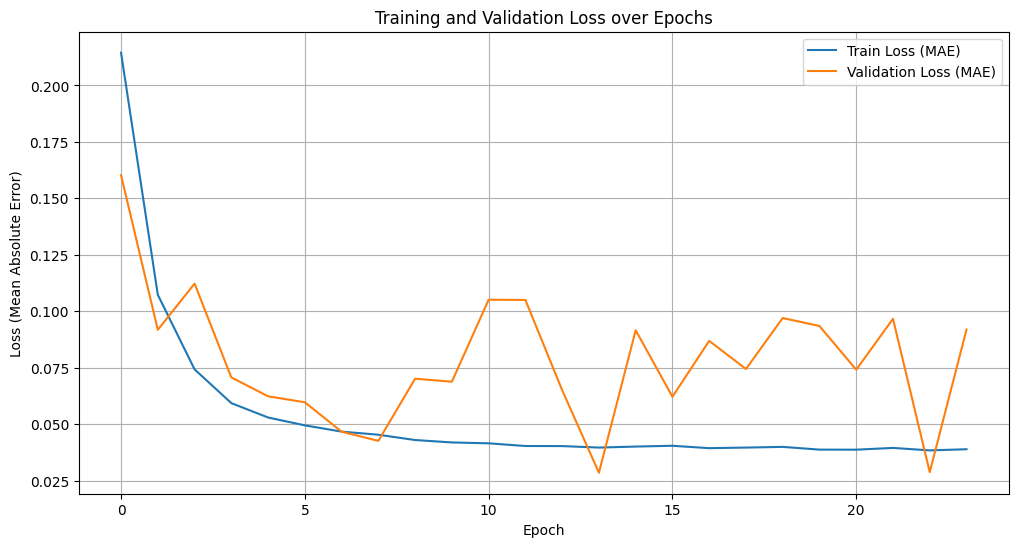

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss (MAE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Absolute Error)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


### Insights

1. **Data Preparation and Feature Engineering**:
    - The dataset was split into training and testing sets based on the season.
    - Several new features were engineered to capture driver and constructor performance, such as average points, consistency, overtaking ability, adaptability, and reliability.
    - Interaction features between drivers and constructors were also created.

2. **Feature Selection**:
    - Key features selected for modeling included driver and constructor average points, consistency, overtaking ability, adaptability, age, reliability, and historical success.

3. **Data Scaling**:
    - Both the features and target variable were scaled using `StandardScaler` to ensure that the model training process is not biased by the scale of the features.

4. **Model Training**:
    - A neural network model was built using TensorFlow and Keras, with two hidden layers and dropout regularization to prevent overfitting.
    - Early stopping was used to halt training when the validation loss stopped improving, ensuring the model does not overfit the training data.

5. **Model Performance**:
    - The model was evaluated on the test set, and the Mean Absolute Error (MAE) and R² score were computed.
    - The test MAE and R² scores provide an indication of how well the model generalizes to unseen data.

6. **Training and Validation Loss**:
    - The plot of training and validation loss over epochs shows the model's learning process.
    - The convergence of training and validation loss indicates that the model is learning effectively without overfitting.

### Inference

- The feature engineering process successfully captured various aspects of driver and constructor performance, which are crucial for predicting race points.
- The relatively low MAE and high R² score on the test set indicate that the model predictions are close to the actual values, and the model explains a significant portion of the variance in the target variable.
- The training and validation loss plot suggests that the model training was stable, and the early stopping mechanism helped in preventing overfitting.

